### Axis Interval Test Dev

In [1]:
import sys
import imp
import os
os.environ['NUMBA_DEBUGINFO'] = '1'
import numpy as np
sys.path.append("../..")
from lib.method.utils import axis_intervals, AxisInterval
from numba.typed import List
import pandas as pd
import xarray as xr

In [2]:
%%time
ais, cis = axis_intervals(100, window=5, target_chunk_size=10)

CPU times: user 746 ms, sys: 23.4 ms, total: 769 ms
Wall time: 767 ms


In [3]:
pd.DataFrame(cis)

,min_index,max_index,min_start,max_stop,count
0,0,4,0,9,25
1,5,9,5,14,25
2,10,14,10,19,25
3,15,19,15,24,25
4,20,24,20,29,25
5,25,29,25,34,25
6,30,34,30,39,25
7,35,39,35,44,25
8,40,44,40,49,25
9,45,49,45,54,25


In [4]:
xr.Dataset.from_dataframe(pd.DataFrame(ais))

<xarray.Dataset>
Dimensions:  (index: 10000000)
Coordinates:
  * index    (index) int64 0 1 2 3 4 ... 9999995 9999996 9999997 9999998 9999999
Data variables:
    start    (index) int64 0 1 2 3 4 ... 9999995 9999996 9999997 9999998 9999999
    stop     (index) int64 10 11 12 13 ... 10000000 10000000 10000000 10000000
    count    (index) int64 10 10 10 10 10 10 10 10 10 10 ... 9 8 7 6 5 4 3 2 1

In [5]:
from lib import api
%run ../../nb/paths.py
# Path to PLINK dataset for demonstration
# path = PLINK_HAPMAP_PATH_01
path = PLINK_1KG_PATH_01
path

PosixPath('/lab/data/gwas/tutorial/2_PS_GWAS/ALL.2of4intersection.20100804.genotypes')

In [6]:
%%time
# Load a dataset to work with
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
ds

CPU times: user 4min 4s, sys: 18.6 s, total: 4min 23s
Wall time: 1min 47s


,Array,Chunk
Bytes,16.03 GB,134.22 MB
Shape,"(25488488, 629)","(213382, 629)"
Count,241 Tasks,120 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,16.03 GB,134.22 MB
Shape,"(25488488, 629)","(213382, 629)"
Count,241 Tasks,120 Chunks
Type,bool,numpy.ndarray
,Array,Chunk


In [9]:
dsf = ds.sel(variant=ds.contig == 1)
dsf

<xarray.Dataset>
Dimensions:     (sample: 629, variant: 2001208)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 2001204 2001205 2001206 2001207
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 622 623 624 625 626 627 628
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(213382, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(213382, 629), meta=np.ndarray>
    sample_id   (sample) object dask.array<chunksize=(629,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(2001208,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(2001208,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(2001208,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(2001208,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(2001208,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(2001208,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

In [12]:
positions = dsf.pos.values
positions.shape

(2001208,)

In [20]:
%%time
ais, cis = axis_intervals(len(positions), window=10000, target_chunk_size=50000, positions=positions)

CPU times: user 324 ms, sys: 28.3 ms, total: 352 ms
Wall time: 346 ms


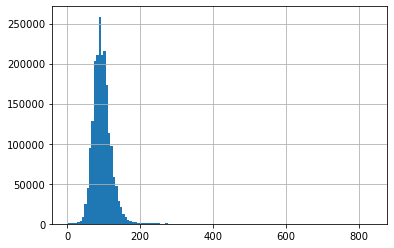

In [29]:
pd.DataFrame(ais)['count'].hist(bins=128)

In [21]:
pd.DataFrame(cis).head()

,min_index,max_index,min_start,max_stop,count
0,0,49853,0,49999,6774785
1,49854,99787,49854,99854,5272394
2,99788,149652,99788,149787,5438070
3,149653,199554,149653,199652,5705983
4,199555,249454,199555,249554,4745567


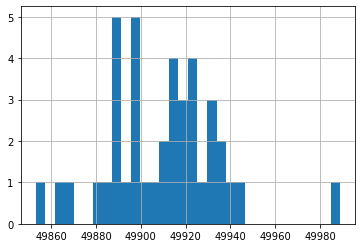

In [28]:
pd.DataFrame(cis)\
    .assign(diff=lambda df: df['max_index'] - df['min_index'])\
    .pipe(lambda df: df[df['diff'] > 10000])['diff'].hist(bins=32)